In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")


In [41]:
data = pd.read_csv('all_stocks_5yr.csv', delimiter=',', on_bad_lines='skip')
print(data.shape)
print(data.sample(7))


(619040, 7)
              date    open    high     low   close    volume  Name
439550  2016-01-29   54.14   55.11   53.93   54.91   3727550   PCG
519678  2013-08-06   35.39   35.41   35.00   35.23   2693321   STI
617092  2015-05-15   29.38   29.38   28.60   28.74   1425803  ZION
161451  2013-06-21   61.28   62.03   60.93   61.07   1288068   DGX
322507  2016-11-15   16.63   17.12   16.33   17.09  26637678   KEY
288503  2015-03-19  100.72  101.30  100.13  100.55    650987   HSY
330047  2014-03-24   97.97   97.97   92.99   94.11   3744737  KORS


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [43]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


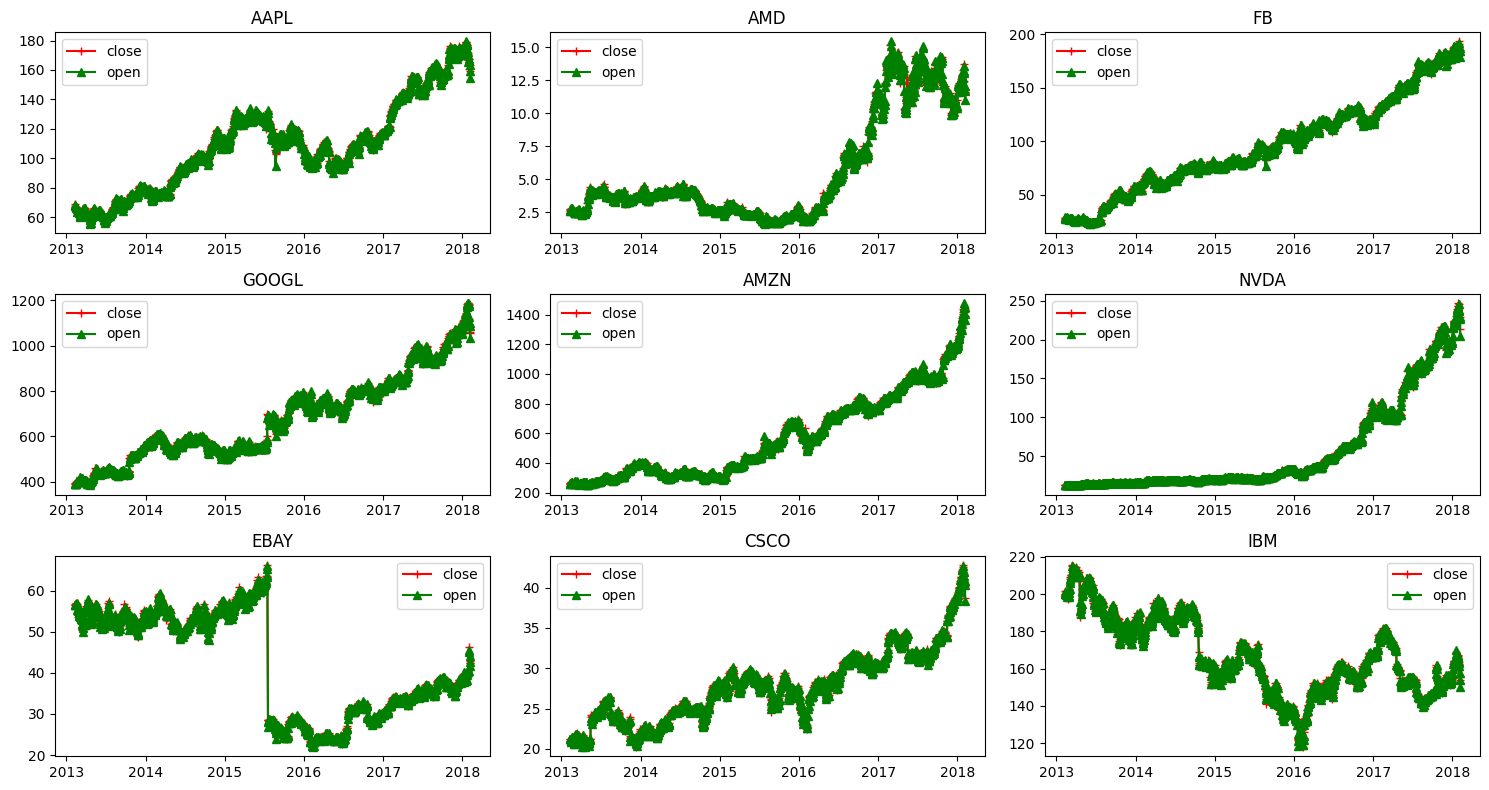

In [44]:
companies = ['AAPL', 'AMD', 'FB', 'GOOGL', 'AMZN', 'NVDA', 'EBAY', 'CSCO', 'IBM']

plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):
    plt.subplot(3, 3, index)
    c = data[data['Name'] == company]
    plt.plot(c['date'], c['close'], c="r", label="close", marker="+")
    plt.plot(c['date'], c['open'], c="g", label="open", marker="^")
    plt.title(company)
    plt.legend()
    plt.tight_layout()



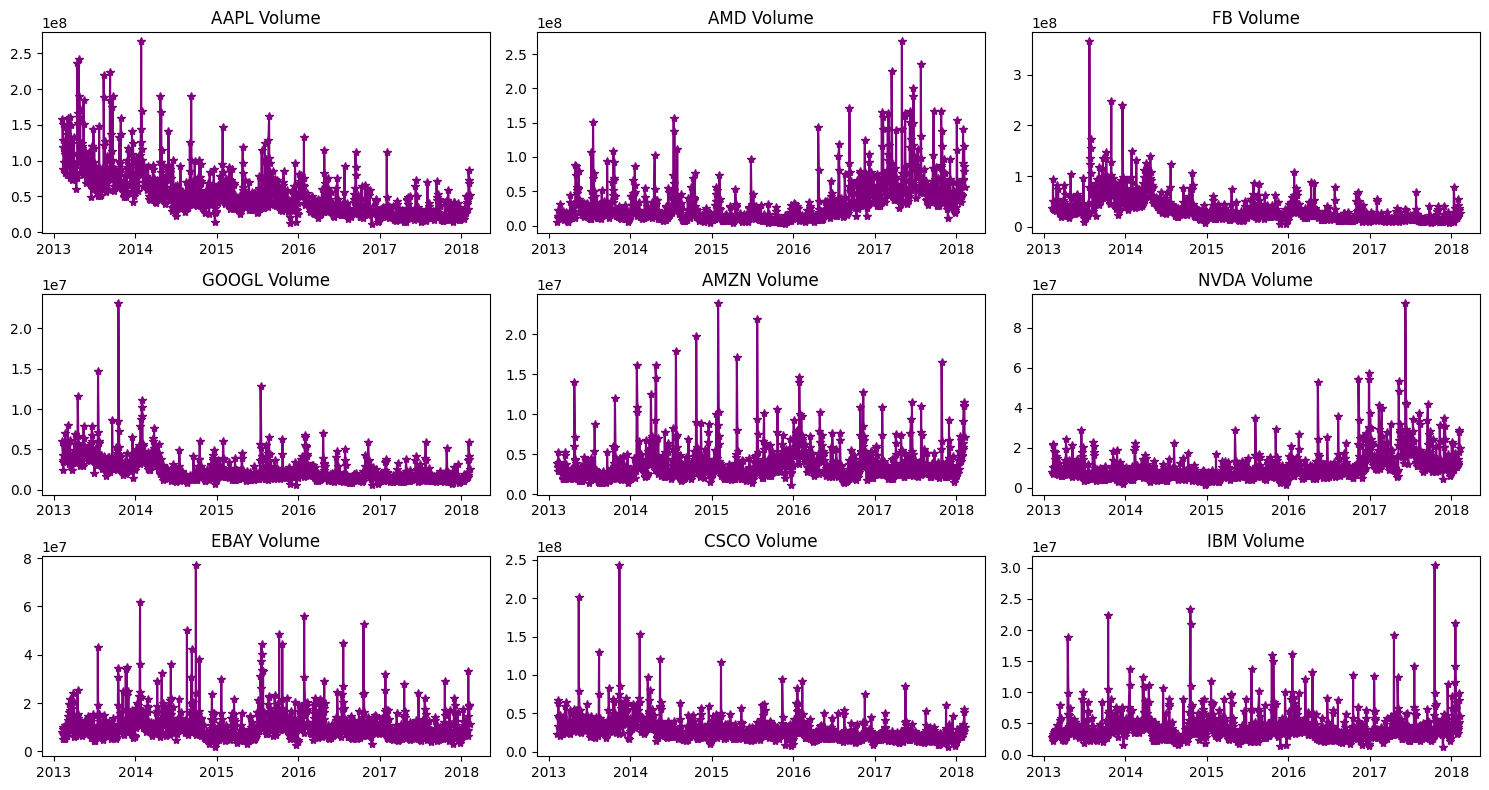

In [45]:
plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):
    plt.subplot(3, 3, index)
    c = data[data['Name'] == company]
    plt.plot(c['date'], c['volume'], c='purple', marker='*')
    plt.title(f"{company} Volume")
    plt.tight_layout()


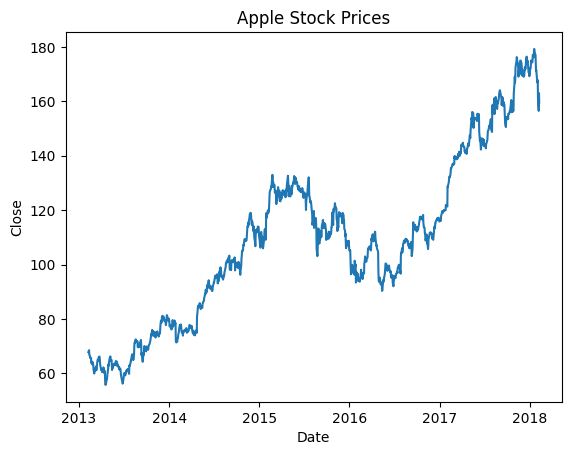

In [46]:
apple = data[data['Name'] == 'AAPL']
prediction_range = apple.loc[(apple['date'] > datetime(2013,1,1))
 & (apple['date']<datetime(2018,1,1))]
plt.plot(apple['date'],apple['close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()


In [47]:
close_data = apple.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

1197


In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [49]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0666
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0108
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0088
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0088
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0088
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0075
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0074
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0069
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0074
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0064


In [51]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

mse = np.mean(((predictions - y_test) ** 2))
rmse = np.sqrt(mse)

print("MSE", mse)
print("RMSE", np.sqrt(mse))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step
MSE 17.376012609758526
RMSE 4.168454462958486


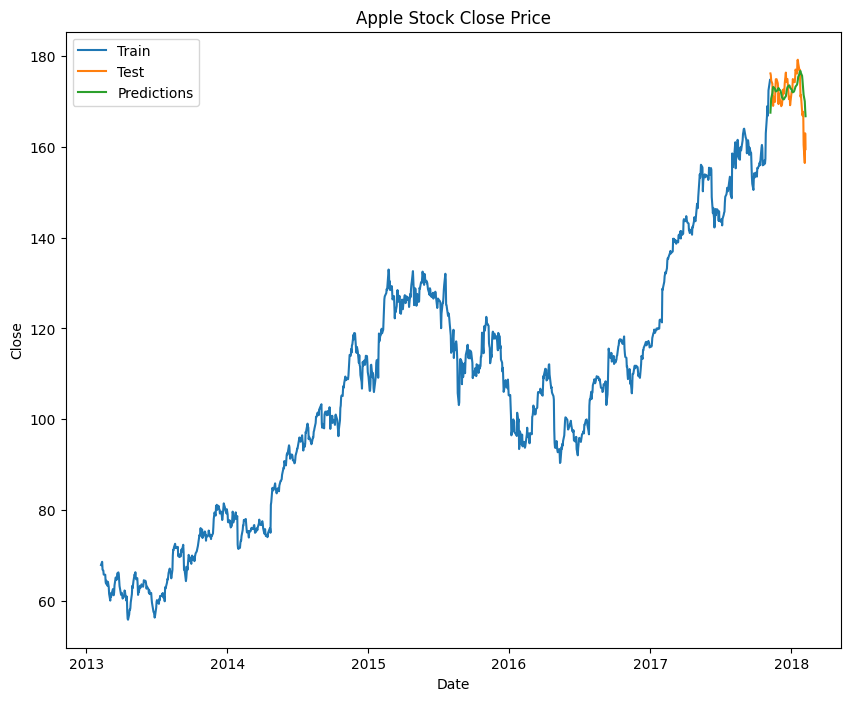

In [52]:
train = apple[:training]
test = apple[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
